## This is a how-to guide for batch effect correction using the `ibaqpy` package.

### 0. After installing the `ibaqpy` package, import the required modules and functions.

In [1]:
# Import the required modules and functions
import pandas as pd
import numpy as np
from ibaqpy.ibaq.ibaqpy_postprocessing import (combine_ibaq_tsv_files,
                                               pivot_wider,
                                               pivot_longer)
from ibaqpy.ibaq.utils import apply_batch_correction

# ignore warnings for this example and make output less verbose
# comment these lines to see the warnings
import warnings
warnings.filterwarnings("ignore")

### 1. Load the data from the raw files

The data is loaded from the raw files in long format. The `combine_ibaq_tsv_files` function
is used to combine multiple TSV files from a directory into a single pandas DataFrame.

In [2]:
# Specific a directory where the data is stored separated by projects
data_dir = "../data/ibaq-raw-hela"
file_pattern = "*ibaq.tsv"

# Load the data
df_ibaq = combine_ibaq_tsv_files(data_dir,
                                 pattern=file_pattern,
                                 comment="#",
                                 sep="\t")

In [3]:
df_ibaq.head()

,ProteinName,SampleID,Condition,NormIntensity,Ibaq,IbaqNorm,IbaqLog,IbaqPpb,MolecularWeight,TPA,CopyNumber,Moles[nmol],Weight[ng],Concentration[nM]
0,A0AVT1,PXD039414-Sample-1,HeLa,2.214399e+04,190.896442,0.000062,5.794457,6229.555761,117895.05750,0.187828,7.474920e+11,0.001241,146.335978,6.345717
1,A0FGR8,PXD039414-Sample-1,HeLa,1.097033e+04,81.261736,0.000027,5.423545,2651.827931,102293.93380,0.107243,4.267920e+11,0.000709,72.496186,3.623184
2,A1L0T0,PXD039414-Sample-1,HeLa,1.683730e+04,224.497357,0.000073,5.864870,7326.060084,67824.74887,0.248247,9.879400e+11,0.001641,111.267361,8.386964
3,A5A3E0,PXD039414-Sample-1,HeLa,1.410006e+06,4351.871586,0.001420,7.152335,142015.358700,121366.69450,11.617737,4.623470e+13,0.076774,9317.864128,392.502132
4,A5YKK6,PXD039414-Sample-1,HeLa,8.718584e+03,24.218287,0.000008,4.897803,790.319456,266767.89780,0.032682,1.300640e+11,0.000216,57.615750,1.104162


### 2. Reshape the data to wide format

This step is necessary to have the samples as columns and the proteins as rows,
which is the format required for batch correction. The fillna==True argument in
the function `pivot_wider` will fill missing values with zero.

In [4]:
# reshape data long to wide format
df_wide = pivot_wider(df_ibaq,
                  row_name="ProteinName",
                  col_name="SampleID",
                  values="Ibaq",
                  fillna=True)

# view
df_wide.iloc[:5, :5]

SampleID,PXD000396-Sample-1,PXD000396-Sample-10,PXD000396-Sample-11,PXD000396-Sample-12,PXD000396-Sample-2
ProteinName,,,,,
A0AV96,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000
A0AVT1,2.720847e+05,9.653710e+05,9.604506e+05,3.320831e+05,231614.6966
A0FGR8,5.185390e+05,1.277410e+06,5.777505e+05,6.119416e+05,517846.8148
A0MZ66,3.749165e+05,0.000000e+00,8.126631e+05,7.755687e+05,430194.5789
A1L0T0,1.215111e+06,0.000000e+00,1.538721e+06,1.657746e+06,706494.8171


### 3. Define the batch index

The batch correction method requires the batch index for each sample. The batch index
is expected to be encoded as integers.

In [5]:
# In this example, the batch information can be extracted directly from the sample names.
# The sample names are in the format: project-sample-id.

batch_ids = df_wide.columns.str.split('-').str[0]
batch_ids = pd.factorize(batch_ids)[0]
print(batch_ids)

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]


### 4. Run batch correction using the `apply_batch_correction` function
The current implementation of the `apply_batch_correction` function uses the `combat-norm`
method from the `inmoose` package.


In [6]:
# Run batch correction
df_corrected = apply_batch_correction(df_wide,
                                      list(batch_ids),
                                      kwargs={})

# view
df_corrected.iloc[:5, :5]

2025-02-04 17:16:43,223 [<module>] - Creating converter from 7 to 5
2025-02-04 17:16:43,224 [<module>] - Creating converter from 5 to 7
2025-02-04 17:16:43,225 [<module>] - Creating converter from 7 to 5
2025-02-04 17:16:43,225 [<module>] - Creating converter from 5 to 7
[INFO] Found 3 batches
2025-02-04 17:16:43,790 [make_design_matrix] - Found 3 batches
[INFO] Adjusting for 0 covariate(s) or covariate level(s)
2025-02-04 17:16:43,791 [make_design_matrix] - Adjusting for 0 covariate(s) or covariate level(s)
[INFO] Standardizing Data across genes.
2025-02-04 17:16:43,792 [calculate_mean_var] - Standardizing Data across genes.
[INFO] Fitting L/S model and finding priors.
2025-02-04 17:16:43,799 [fit_model] - Fitting L/S model and finding priors.
[INFO] Finding parametric adjustments.
2025-02-04 17:16:43,804 [fit_model] - Finding parametric adjustments.
[INFO] Adjusting the Data
2025-02-04 17:16:43,893 [adjust_data] - Adjusting the Data


SampleID,PXD000396-Sample-1,PXD000396-Sample-10,PXD000396-Sample-11,PXD000396-Sample-12,PXD000396-Sample-2
ProteinName,,,,,
A0AV96,-10573.225542,-10573.225542,-10573.225542,-10573.225542,-10573.225542
A0AVT1,54909.126948,423101.593009,420488.433500,86773.263583,33416.199278
A0FGR8,125548.093844,529228.366110,157045.520656,175233.429583,125179.875230
A0MZ66,77346.858130,-121586.692518,309618.565697,289935.978003,106677.835886
A1L0T0,386327.210311,-258717.830880,558116.508835,621301.217192,116326.977811


### 5. Reshape the data back to long format

This step is necessary to enable further downstream analysis using
other functionalities in the `ibaqpy` package. It also allows for easy
visualization of data.

In [7]:
# reshape data wide to long format
df_long = pivot_longer(df_corrected,
                       row_name="ProteinName",
                       col_name="SampleID",
                       values="Ibaq_corrected")

# view
df_long.head()

,ProteinName,SampleID,Ibaq_corrected
0,A0AV96,PXD000396-Sample-1,-10573.225542
1,A0AVT1,PXD000396-Sample-1,54909.126948
2,A0FGR8,PXD000396-Sample-1,125548.093844
3,A0MZ66,PXD000396-Sample-1,77346.858130
4,A1L0T0,PXD000396-Sample-1,386327.210311


### 6. Compare the corrected and raw data using boxplot.

In [8]:
# Define a function to generate a boxplot for protein expression distribution per sample
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

def generate_boxplot(df,
                     x='SampleID',
                     y='ibaQ',
                     hue='Project',
                     project_colors_hex=None,
                     title='Protein expression distribution per sample',
                     xlabel='Samples',
                     ylabel='iBAQ',
                     save_path=None,
                     figsize=(15, 8),
                     rotation=45,
                     dpi=300):
    """
    Generate a box plot for protein expression distribution per sample.

    Parameters:
    - df: DataFrame containing the dataset.
    - x: Column name for the x-axis (e.g., sample identifiers).
    - y: Column name for the y-axis (e.g., protein expression values).
    - hue: Column name that indicates the project.
    - project_colors_hex: (Optional) Dictionary mapping project names to colors.
      If provided, boxes will be colored accordingly.
    - title: Title of the plot.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    - save_path: Path to save the plot image (if provided).
    - figsize: Size of the figure.
    - rotation: Rotation angle for x-axis labels.
    - dpi: Dots per inch for the saved image.
    """
    plt.figure(figsize=figsize)

    # remove NaN values from the dataset
    df = df.dropna(subset=[x, y, hue])

    # sort the dataset by the x/hue columns
    df = df.sort_values(by=[x, hue])

    # Get unique sample identifiers
    samples = df[x].unique()
    scale_factor = 0.7  # Adjust this factor to decrease the distance between boxes

    # Create a list to store the x positions for ticks
    positions = []

    for i, s in enumerate(samples):
        # Extract the data for the current sample
        sample_data = df[df[x] == s][y].values

        # Assume each sample is linked to one project; get that project value.
        project = df[df[x] == s][hue].iloc[0]

        # Determine the x position for this boxplot
        pos = i * scale_factor
        positions.append(pos)

        # Plot the boxplot for this sample at the specified position.
        box = plt.boxplot(sample_data,
                          positions=[pos],
                          widths=0.4,
                          patch_artist=True,
                          flierprops=dict(marker='o', markersize=3))

        # Set the face color of the box based on the project's color if a mapping is provided.
        # If no mapping is provided or the project is not found in the dictionary, the default color is used.
        if project_colors_hex:
            color = project_colors_hex.get(project)
            if color:  # Only set the color if a valid one was found
                for patch in box['boxes']:
                    patch.set_facecolor(color)

    # Set plot title and axis labels
    plt.title(title, fontsize=10)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    # Set the x-axis ticks to correspond to our boxplot positions and sample labels.
    plt.xticks(ticks=positions, labels=samples, rotation=rotation, fontsize=6)

    plt.tight_layout()

    # Save the figure only if a save path is provided.
    if save_path:
        plt.savefig(save_path, dpi=dpi)

    plt.show()

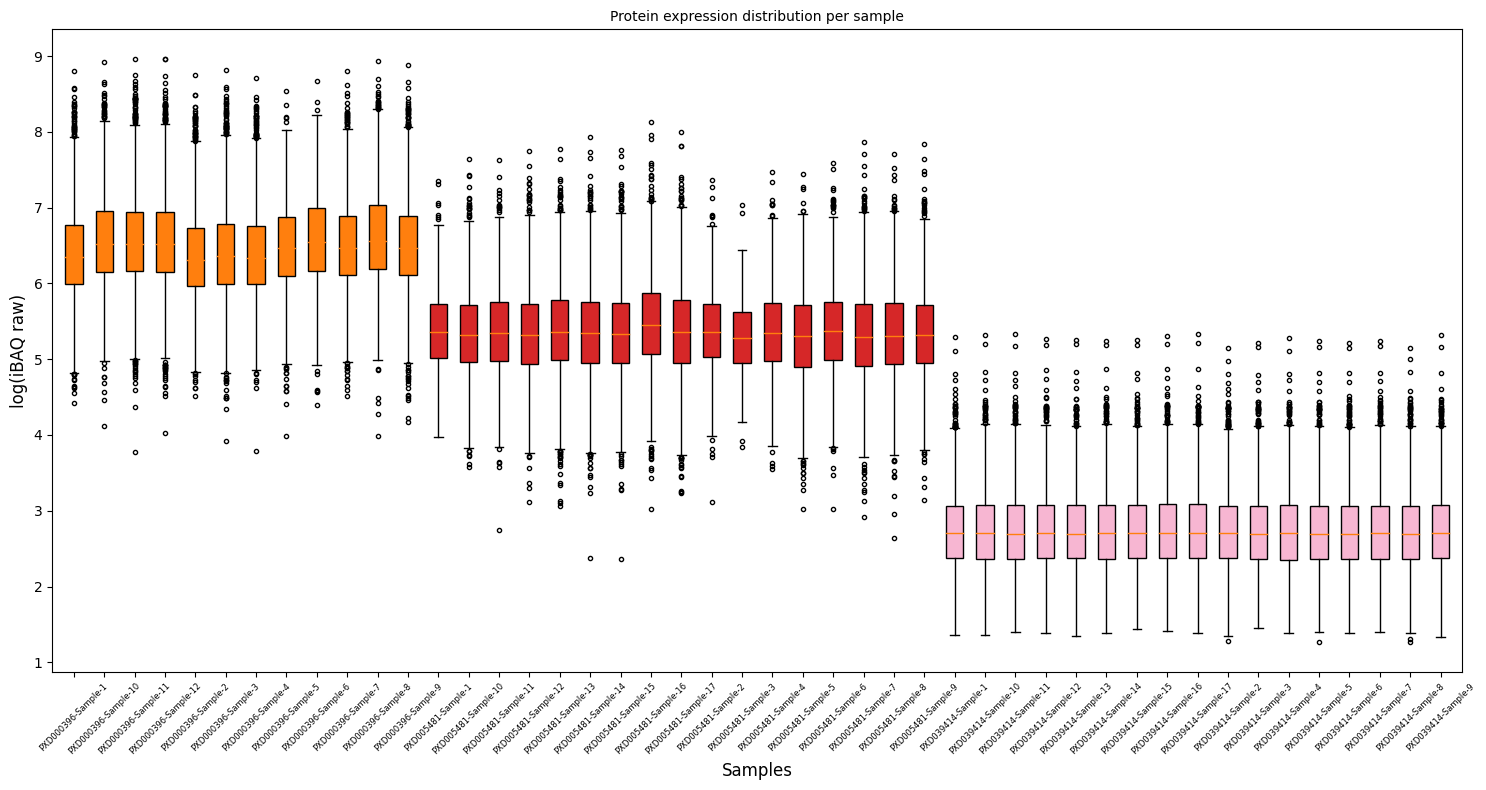

In [9]:
# 6.1 Generate a boxplot for protein expression distribution per sample
# for the raw data in long format

# Add project information to the corrected dataset
# from the SampleID column
df_ibaq['Project'] = df_ibaq['SampleID'].str.split('-').str[0]

# transform ibaq values to log scale
df_ibaq['Ibaq_log'] = np.log10(df_ibaq['Ibaq'] + 10)

# Define project colors
project_colors_map = {
    'PXD000396': '#ff7f0e',
    'PXD005481': '#d62728',
    'PXD039414': '#f7b6d2',
}


generate_boxplot(df_ibaq,
                    x='SampleID',
                    y='Ibaq_log',
                    hue='Project',
                    project_colors_hex=project_colors_map,
                    title='Protein expression distribution per sample',
                    xlabel='Samples',
                    ylabel='log(iBAQ raw)',
                    save_path='../data/ibaq-raw-hela/boxplot-raw.png',
                    figsize=(15, 8),
                    rotation=45,
                    dpi=300);

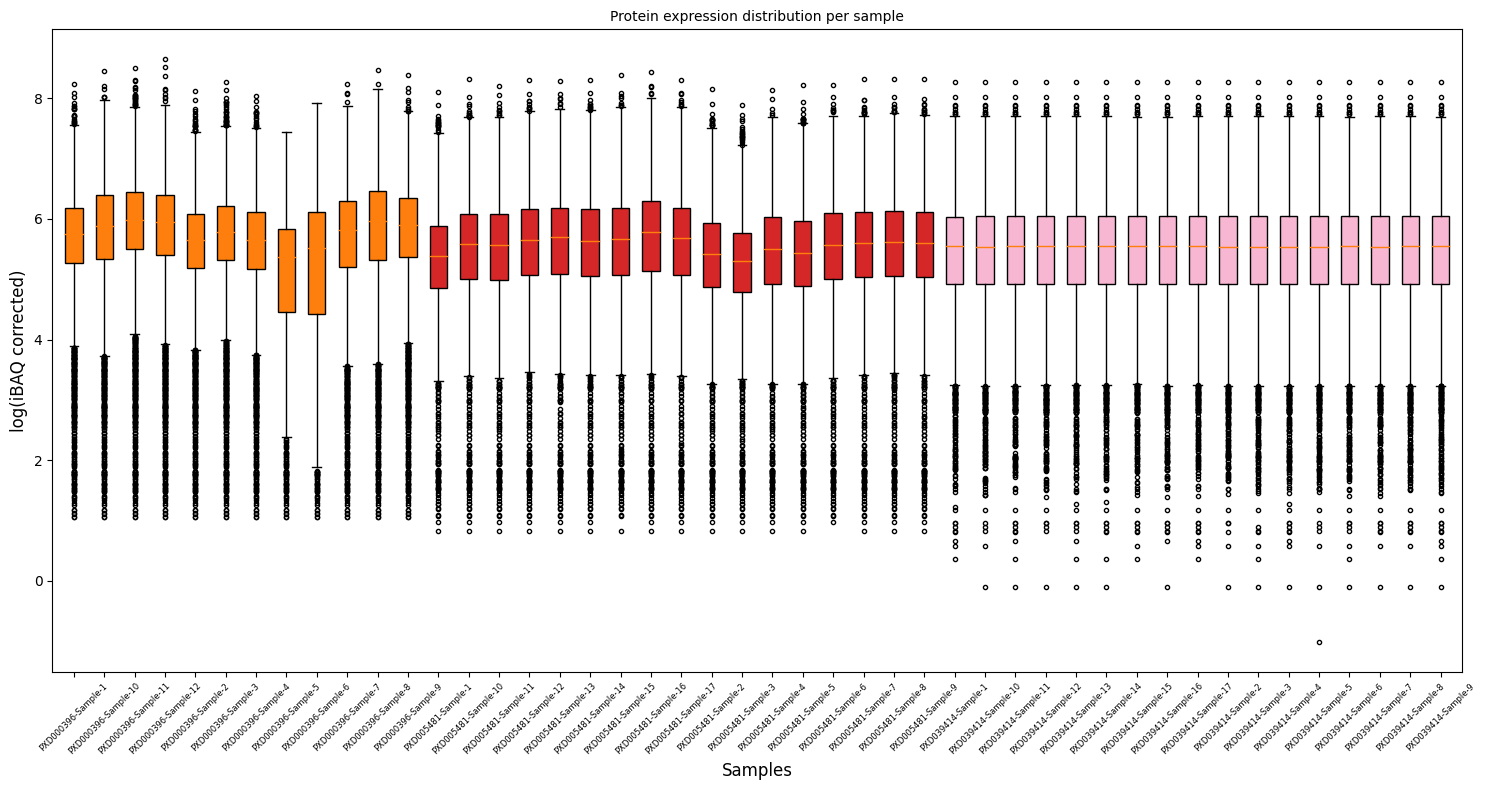

In [10]:
# 6.2 Generate a boxplot for protein expression distribution per sample
# for the corrected data in long format

# Add project information to the corrected dataset
# from the SampleID column
df_long['Project'] = df_long['SampleID'].str.split('-').str[0]

# transform ibaq values to log scale
df_long['Ibaq_log'] = np.log10(df_long['Ibaq_corrected'] + 10)

generate_boxplot(df_long,
                 x='SampleID',
                 y='Ibaq_log',
                 hue='Project',
                 project_colors_hex=project_colors_map,
                 title='Protein expression distribution per sample',
                 xlabel='Samples',
                 ylabel='log(iBAQ corrected)',
                 save_path='../data/ibaq-raw-hela/boxplot.png',
                 figsize=(15, 8),
                 rotation=45,
                 dpi=300);